*Note that most of the code cells are hidden from this notebook for a better reading flow. Check out the notebook in the documentation folder in the Github repository for more details.*

# Replicating Keane and Wolpin (1994)

Keane and Wolpin (1994) and the previously published working paper Keane and Wolpin (1994b) generate three different Monte Carlo samples. This notebook replicates some of their results as well as giving other insights into the model.

## Returns to experience

We first plot the returns to experience while holding education constant at the initial ten years. Occupation B is more skill intensive in the sense that own experience has higher return than is the case for Occupation A. There is some general skill learned in Occupation A which is transferable to Occupation B. However, work experience is occupation-specific in Occupation B.

In [14]:
%matplotlib agg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import respy as rp
import warnings

from mpl_toolkits.mplot3d import Axes3D

In [15]:
plt.style.use("../_static/respy.mplstyle")

In [16]:
# Load example model and convert parameter and options to model attributes.
params, options = rp.get_example_model("kw_94_one", with_data=False)

In [17]:
ret_schooling_occ_a = params.loc[("wage_a", "exp_edu"), "value"]
ret_schooling_occ_b = params.loc[("wage_b", "exp_edu"), "value"]

ret_exp_a_occ_a = params.loc[("wage_a", "exp_a"), "value"]
ret_exp_a_sq_occ_a = params.loc[("wage_a", "exp_a_square"), "value"]
ret_exp_b_occ_a = params.loc[("wage_a", "exp_b"), "value"]
ret_exp_b_sq_occ_a = params.loc[("wage_a", "exp_b_square"), "value"]
log_rental_price_occ_a = params.loc[("wage_a", "constant"), "value"]

ret_exp_a_occ_b = params.loc[("wage_b", "exp_a"), "value"]
ret_exp_a_sq_occ_b = params.loc[("wage_b", "exp_a_square"), "value"]
ret_exp_b_occ_b = params.loc[("wage_b", "exp_b"), "value"]
ret_exp_b_sq_occ_b = params.loc[("wage_b", "exp_b_square"), "value"]
log_rental_price_occ_b = params.loc[("wage_b", "constant"), "value"]

In [18]:
x, y = np.meshgrid(range(0, 20), range(0, 20))

z_a = np.exp(
    log_rental_price_occ_a + ret_schooling_occ_a * 10
    + ret_exp_a_occ_a * x + ret_exp_a_sq_occ_a * x ** 2 / 100
    + ret_exp_b_occ_a * y + ret_exp_b_sq_occ_a * y ** 2 / 100
)

z_b = np.exp(
    log_rental_price_occ_b + ret_schooling_occ_b * 10
    + ret_exp_a_occ_b * x + ret_exp_a_sq_occ_b * x ** 2 / 100
    + ret_exp_b_occ_b * y + ret_exp_b_sq_occ_b * y ** 2 / 100
)

In [19]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax1.plot_surface(x, y, z_a / 1000, cmap="Greens")
ax2.plot_surface(x, y, z_b / 1000, cmap="Reds")

for ax in [ax1, ax2]:
    ax.set_xticks(range(0, 21, 5))
    ax.set_yticks(range(0, 21, 5))
    ax.set_zticks(range(10, 36, 5))
    ax.set_zticklabels(range(10, 36, 5))
    ax.set_zlim(10, 35)
#     ax.invert_xaxis()
    ax.set_xlabel("Experience A")
    ax.set_ylabel("Experience B")
    ax.set_proj_type('ortho')
    ax.set_zlabel("Wages in (\$1,000)", labelpad=-1)
    
ax1.set_title("(a)", y=-0.15)
ax2.set_title("(b)", y=-0.15)

# plt.subplots_adjust(wspace=1)
plt.tight_layout()

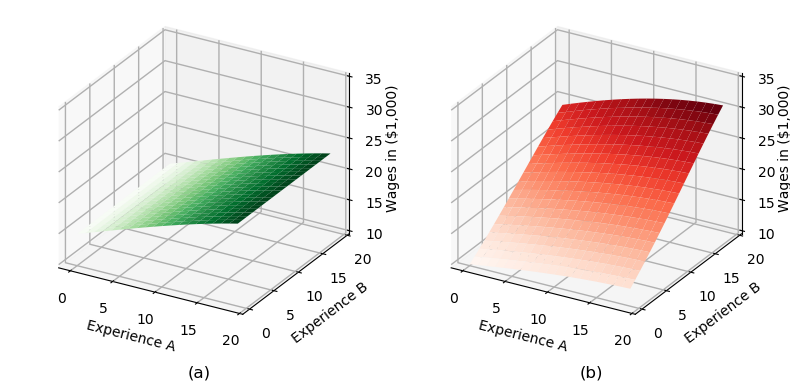

In [20]:
fig

The next figure shows that the returns to schooling are larger in Occupation B. While its initial wage is lower, it does increase faster with schooling compared to Occupation A. The graphs are generated by holding experience in both sectors constant at five years.

In [21]:
years_schooling = np.arange(10, 21)

wage_a = np.exp(
    log_rental_price_occ_a + ret_schooling_occ_a * years_schooling
    + ret_exp_a_occ_a * 5 + ret_exp_a_sq_occ_a * 5 ** 2 / 100
    + ret_exp_b_occ_a * 5 + ret_exp_b_sq_occ_a * 5 ** 2 / 100
)

wage_b = np.exp(
    log_rental_price_occ_b + ret_schooling_occ_b * years_schooling
    + ret_exp_a_occ_b * 5 + ret_exp_a_sq_occ_b * 5 ** 2 / 100
    + ret_exp_b_occ_b * 5 + ret_exp_b_sq_occ_b * 5 ** 2 / 100
)

fig, ax = plt.subplots()

ax.plot(years_schooling, wage_a / 1000, color="C2", label="Occupation A")
ax.plot(years_schooling, wage_b / 1000, color="C3", label="Occupation B")

ax.set_xlim(10, 20)
ax.set_ylim(14, 30)
ax.set_yticks(range(16, 31, 2))

ax.set_xlabel("Years of Schooling")
ax.set_ylabel("Wages (in \$1,000)")

ax.legend();

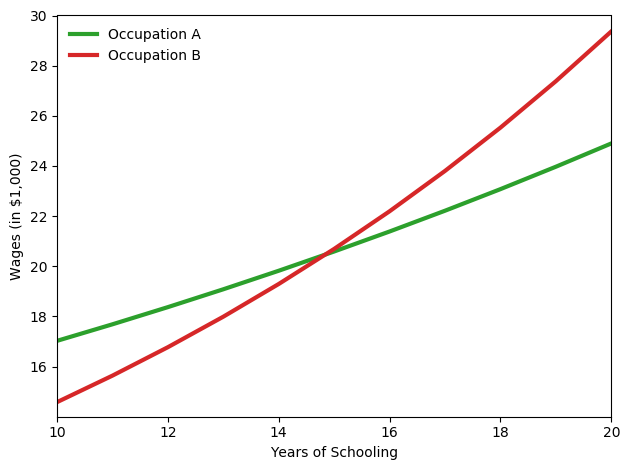

In [22]:
fig

## Effect of college tuition subsidy

This section replicates Table 6 in Keane and Wolpin (1994) which studies the effect of different amounts of tuition subsidies. First, we are going to show the effect of the tuition subsidy on each of the parametrizations for a sample of 1,000 simulated individuals. After that, Table 6 is replicated where the policy effect is measured as the average difference in experience for 40 samples with 100 invididuals with and without the tutition subsidy. The authors apply a 500 USD tuition subsidy on the first parametrization, 1000 USD on the second and 2000 USD on the third parametrization.

The following figures show the impact of the tuition subsidies for each of the parametrizations next to each other.

In [23]:
# Build simulate function as only parameters change, it can be reused.
params, options, _ = rp.get_example_model("kw_94_one")
options["simulation_agents"] = 4000
simulate = rp.get_simulate_func(params, options)

models = np.repeat(["one", "two", "three"], 2)
tuition_subsidies = [0, 500, 0, 1000, 0, 2000]

data_frames = []

for model, tuition_subsidy in zip(models, tuition_subsidies):
    params, _, _ = rp.get_example_model(f"kw_94_{model}")
    params.loc[("nonpec_edu", "hs_graduate"), "value"] += tuition_subsidy
    data_frames.append(simulate(params))

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), sharey=True, sharex=True)

axs = axs.flatten()

for df, ax, model, tuition_subsidy in zip(data_frames, axs, models, tuition_subsidies):
    shares = df.groupby("Period").Choice.value_counts(normalize=True).unstack()[["home", "edu", "a", "b"]]

    shares.plot.bar(stacked=True, ax=ax, width=1, legend=True)

    ax.set_ylim(0, 1)
    ax.set_xticks(range(0, 40, 5))
    ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")
    ax.set_ylabel("Share of population")
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(f"Parametrization {model.title()} \n with a tuition subsidy of {tuition_subsidy} USD")
    
fig.legend(
    handles,
    ["Home", "Education", "A", "B"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=4
);

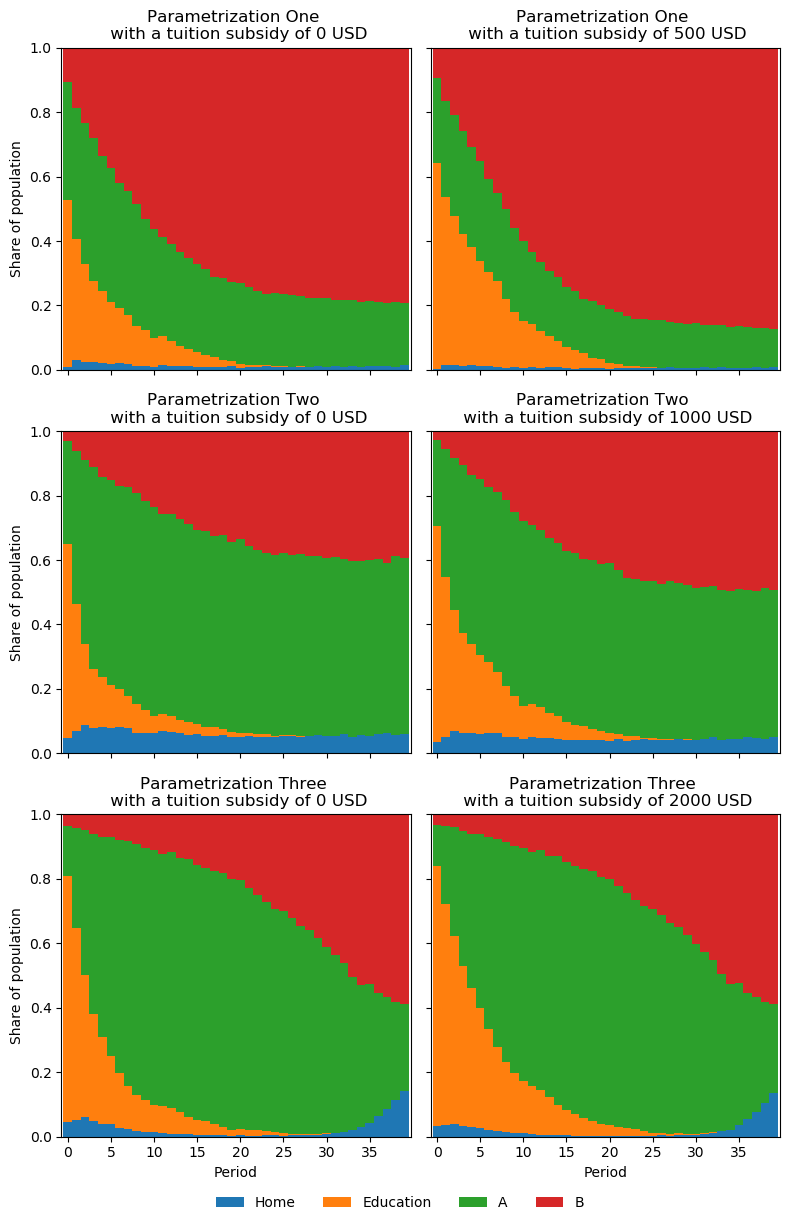

In [25]:
fig

In [52]:
df["Bootstrap_Sample"] = pd.cut(df.Identifier, bins=40, labels=np.arange(1, 41))

In [85]:
bootstrapped_statistics = []

for i, title in zip(range(0, 6, 2), ["Data Set One", "Data Set Two", "Data Set Three"]):
    df_wo_ts = data_frames[i]
    df_w_ts = data_frames[i + 1]
    
    # Split the sample in 40 parts.
    df_wo_ts["Bootstrap_Sample"] = pd.cut(df_wo_ts.Identifier, bins=40, labels=np.arange(1, 41))
    df_w_ts["Bootstrap_Sample"] = pd.cut(df_w_ts.Identifier, bins=40, labels=np.arange(1, 41))
    
    mean_exp_wo_ts = df_wo_ts.loc[df_wo_ts.Period.eq(39), ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B"]].groupby("Bootstrap_Sample").mean()
    mean_exp_w_ts = df_w_ts.loc[df_w_ts.Period.eq(39), ["Bootstrap_Sample", "Experience_Edu", "Experience_A", "Experience_B"]].groupby("Bootstrap_Sample").mean()
    
    diff = mean_exp_w_ts - mean_exp_wo_ts
    diff["Data"] = title
    diff = diff.reset_index().set_index(["Data", "Bootstrap_Sample"]).stack().unstack([0, 2])
    bootstrapped_statistics.append(diff)

In [86]:
pd.concat([bs.agg(["mean", "std"]) for bs in bootstrapped_statistics], axis=1)

Data Set One                             Data Set Two               \
     Experience_Edu Experience_A Experience_B Experience_Edu Experience_A   
mean       1.541750    -3.345750     2.004500       1.302750    -3.071750   
std        0.229759     0.966203     0.886161       0.207895     0.501679   

                  Data Set Three                            
     Experience_B Experience_Edu Experience_A Experience_B  
mean      2.29375       1.706000    -1.260250    -0.245250  
std       0.41365       0.189883     0.180732     0.121655

## Choice distributions

This section replicates the choice distributions for all three models. The distributions are based on 1,000 simulated agents.

In [26]:
params, options, _ = rp.get_example_model("kw_94_one")

In [27]:
df = simulate(params)

In [28]:
resources = rp.config.TEST_RESOURCES_DIR

In [29]:
df_ = pd.read_csv(resources / "kw_94_wp_table_2_1.csv")

In [30]:
df_.head()

,period,a,b,edu,home
0,1,0.386,0.116,.490,.008
1,2,0.427,0.175,.354,.044
2,3,0.444,0.220,.308,.028
3,4,0.459,0.263,.255,.023
4,5,0.417,0.332,.218,.033


In [31]:
df.groupby("Period").Choice.value_counts(normalize=True).unstack().head()

Choice,a,b,edu,home
Period,,,,
0,0.36675,0.10550,0.51875,0.00900
1,0.40825,0.18575,0.37675,0.02925
2,0.43825,0.23425,0.30300,0.02450
3,0.44200,0.28175,0.25275,0.02350
4,0.41975,0.33550,0.22375,0.02100


In [32]:
df.groupby("Period").Choice.value_counts(normalize=True).unstack().head()

Choice,a,b,edu,home
Period,,,,
0,0.36675,0.10550,0.51875,0.00900
1,0.40825,0.18575,0.37675,0.02925
2,0.43825,0.23425,0.30300,0.02450
3,0.44200,0.28175,0.25275,0.02350
4,0.41975,0.33550,0.22375,0.02100


## References

> Keane, M. P. and  Wolpin, K. I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://doi.org/10.2307/2109768). *The Review of Economics and Statistics*, 76(4): 648-672.

> Keane, M. P. and  Wolpin, K. I. (1994b). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://www.minneapolisfed.org/research/staff-reports/the-solution-and-estimation-of-discrete-choice-dynamic-programming-models-by-simulation-and-interpolation-monte-carlo-evidence). *Federal Reserve Bank of Minneapolis*, No. 181.